In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import ggplot, aes, geom_line, ggtitle, xlab, ylab
import plotnine as gg
import statsmodels.api as sm

In [238]:
# Read data
data = pd.read_csv("wind-power-production-us.csv")

In [240]:
print(data.head())

       date  other_united_states  other_new_england  other_connecticut  \
0  Jan 2001                 6025                678                 75   
1  Feb 2001                 5310                599                 77   
2  Mar 2001                 5795                660                 96   
3  Apr 2001                 5827                593                 92   
4  May 2001                 5738                640                 72   

   other_maine  other_massachusetts  other_new_hampshire  other_rhode_island  \
0          348                  113                   91                  10   
1          293                  103                   83                   9   
2          327                  101                   93                   9   
3          277                  106                   81                   9   
4          336                  109                   86                   9   

   other_vermont  other_middle_atlantic  ...  wind_new_mexico  wind_utah  

In [242]:
# Create time series
wind_power_production = pd.Series(data['wind_united_states'].values, 
                                  index=pd.date_range(start='2001-01', periods=len(data), freq='ME'))
wind_power_production_log = np.log(wind_power_production)

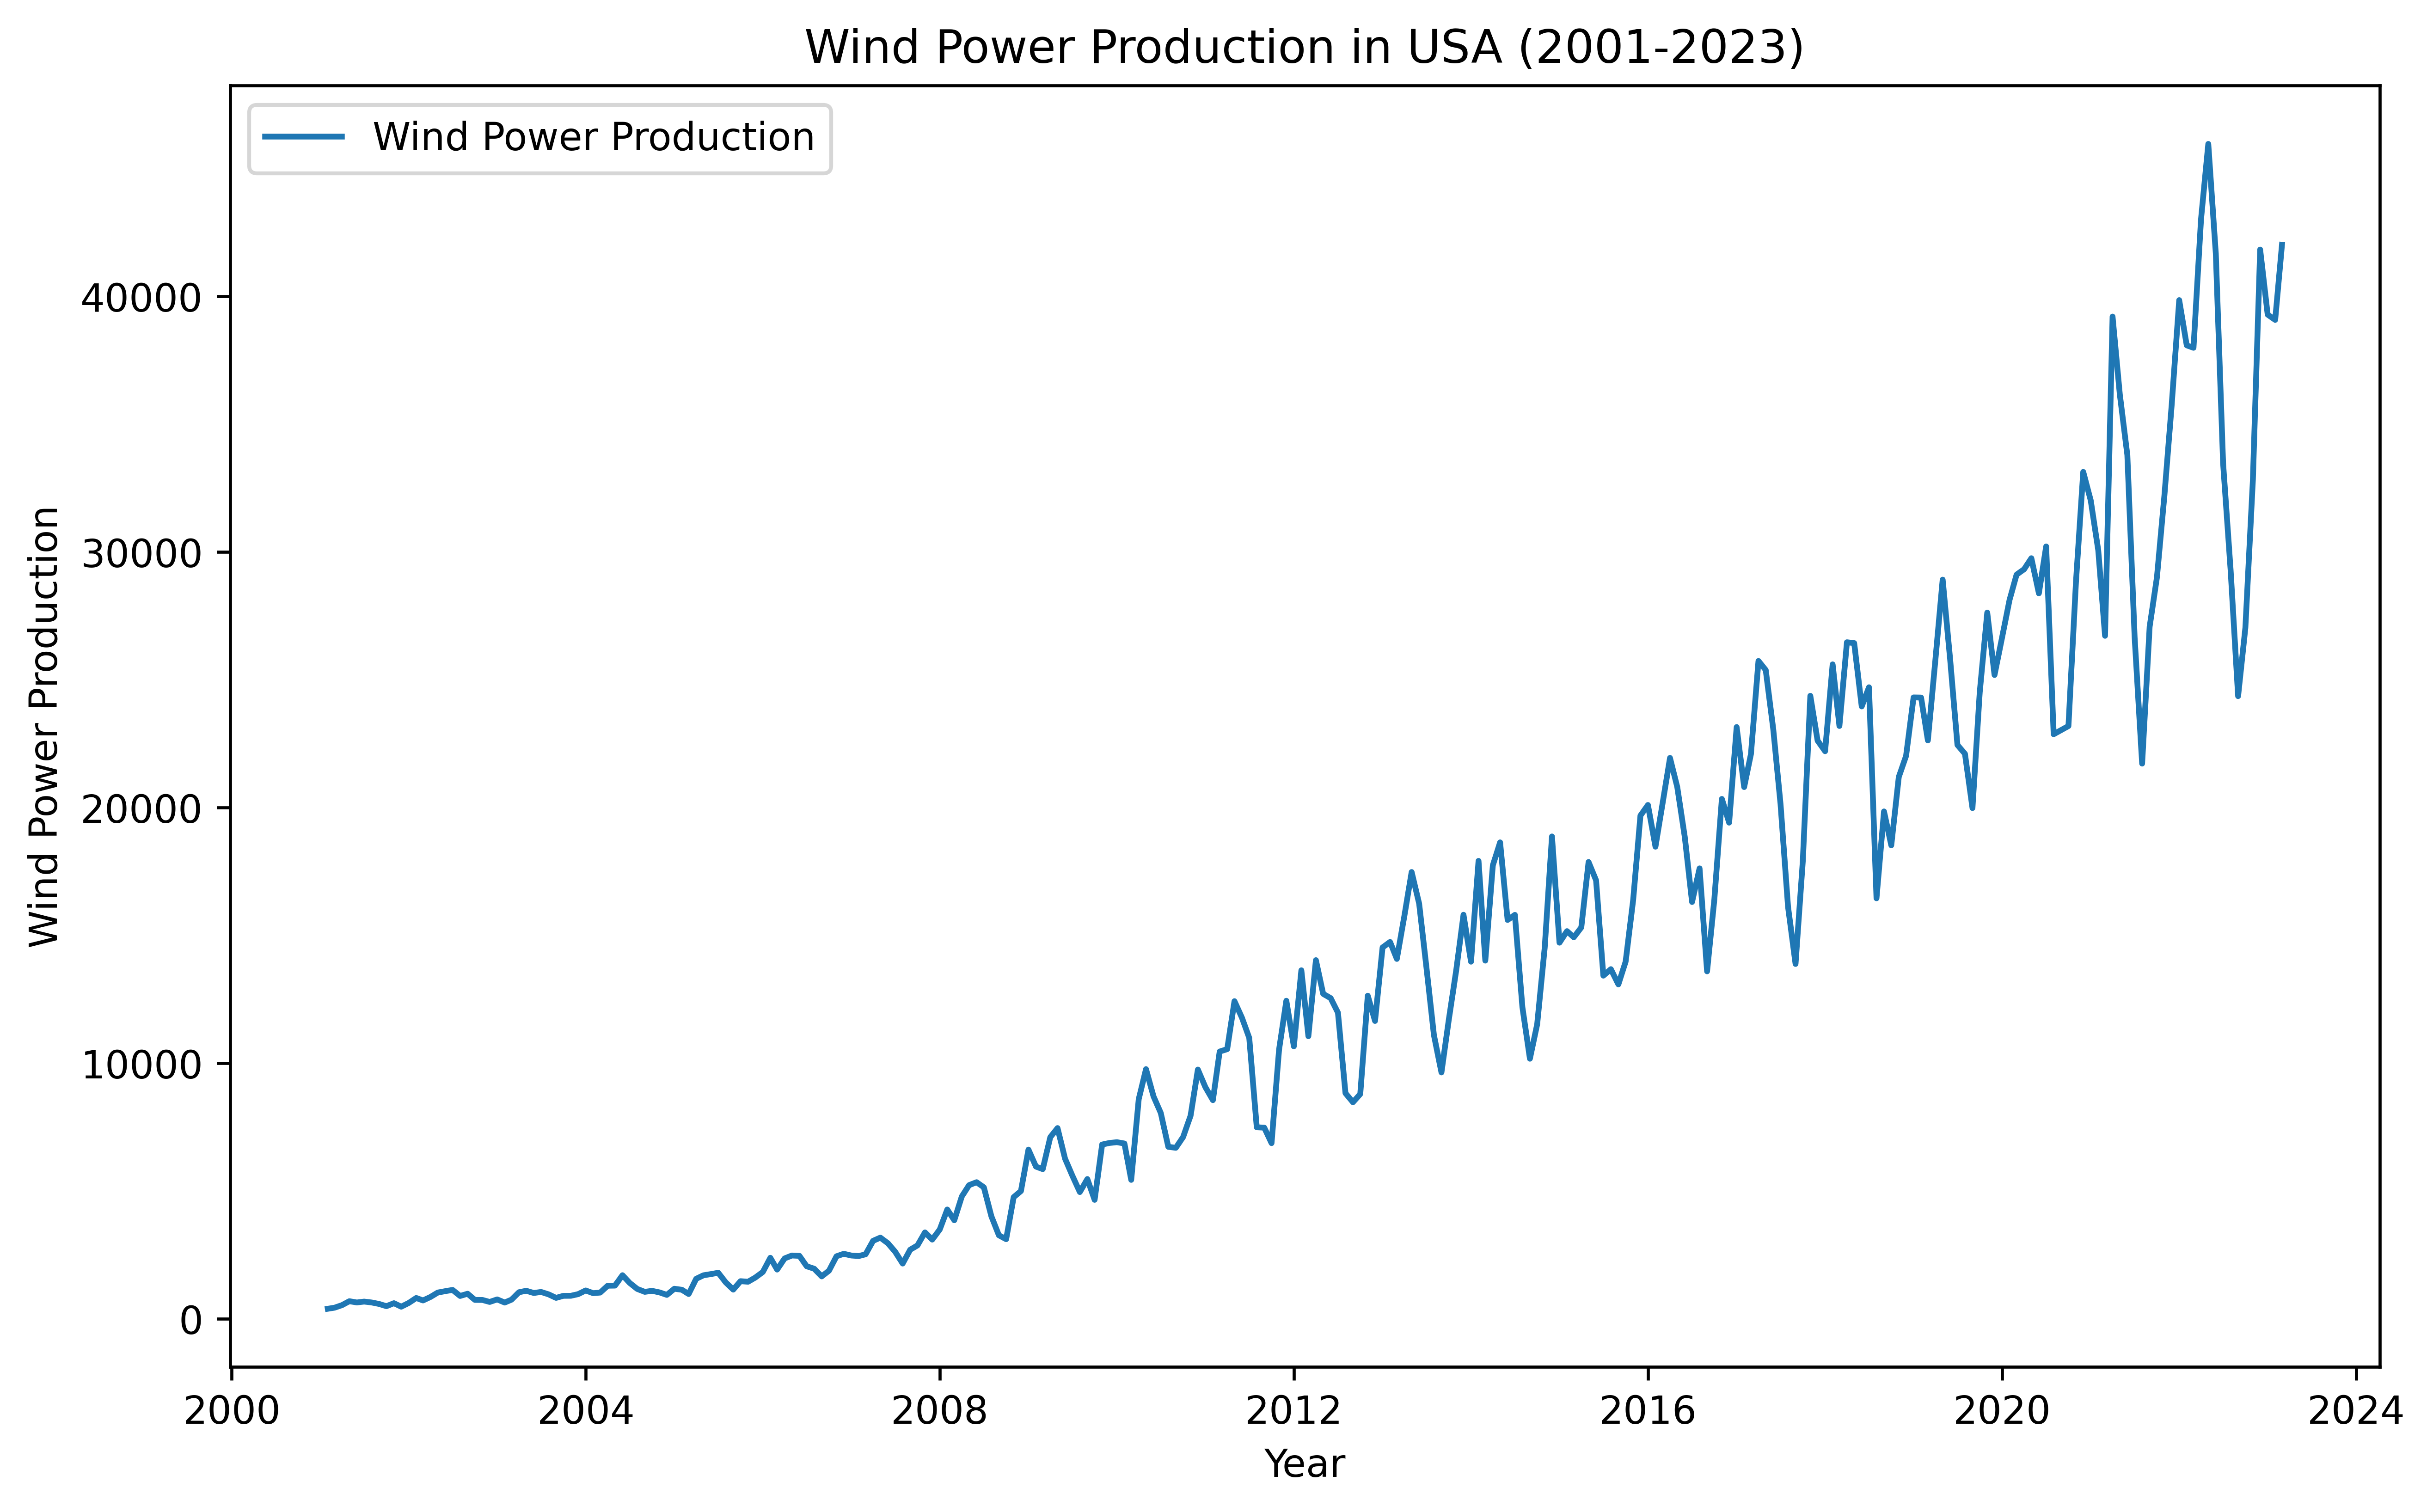

In [328]:
# Plot wind power production
plt.figure(figsize=(10, 6), dpi=600)
plt.plot(wind_power_production, label="Wind Power Production")
plt.title("Wind Power Production in USA (2001-2023)")
plt.xlabel("Year")
plt.ylabel("Wind Power Production")
plt.legend()
plt.show()

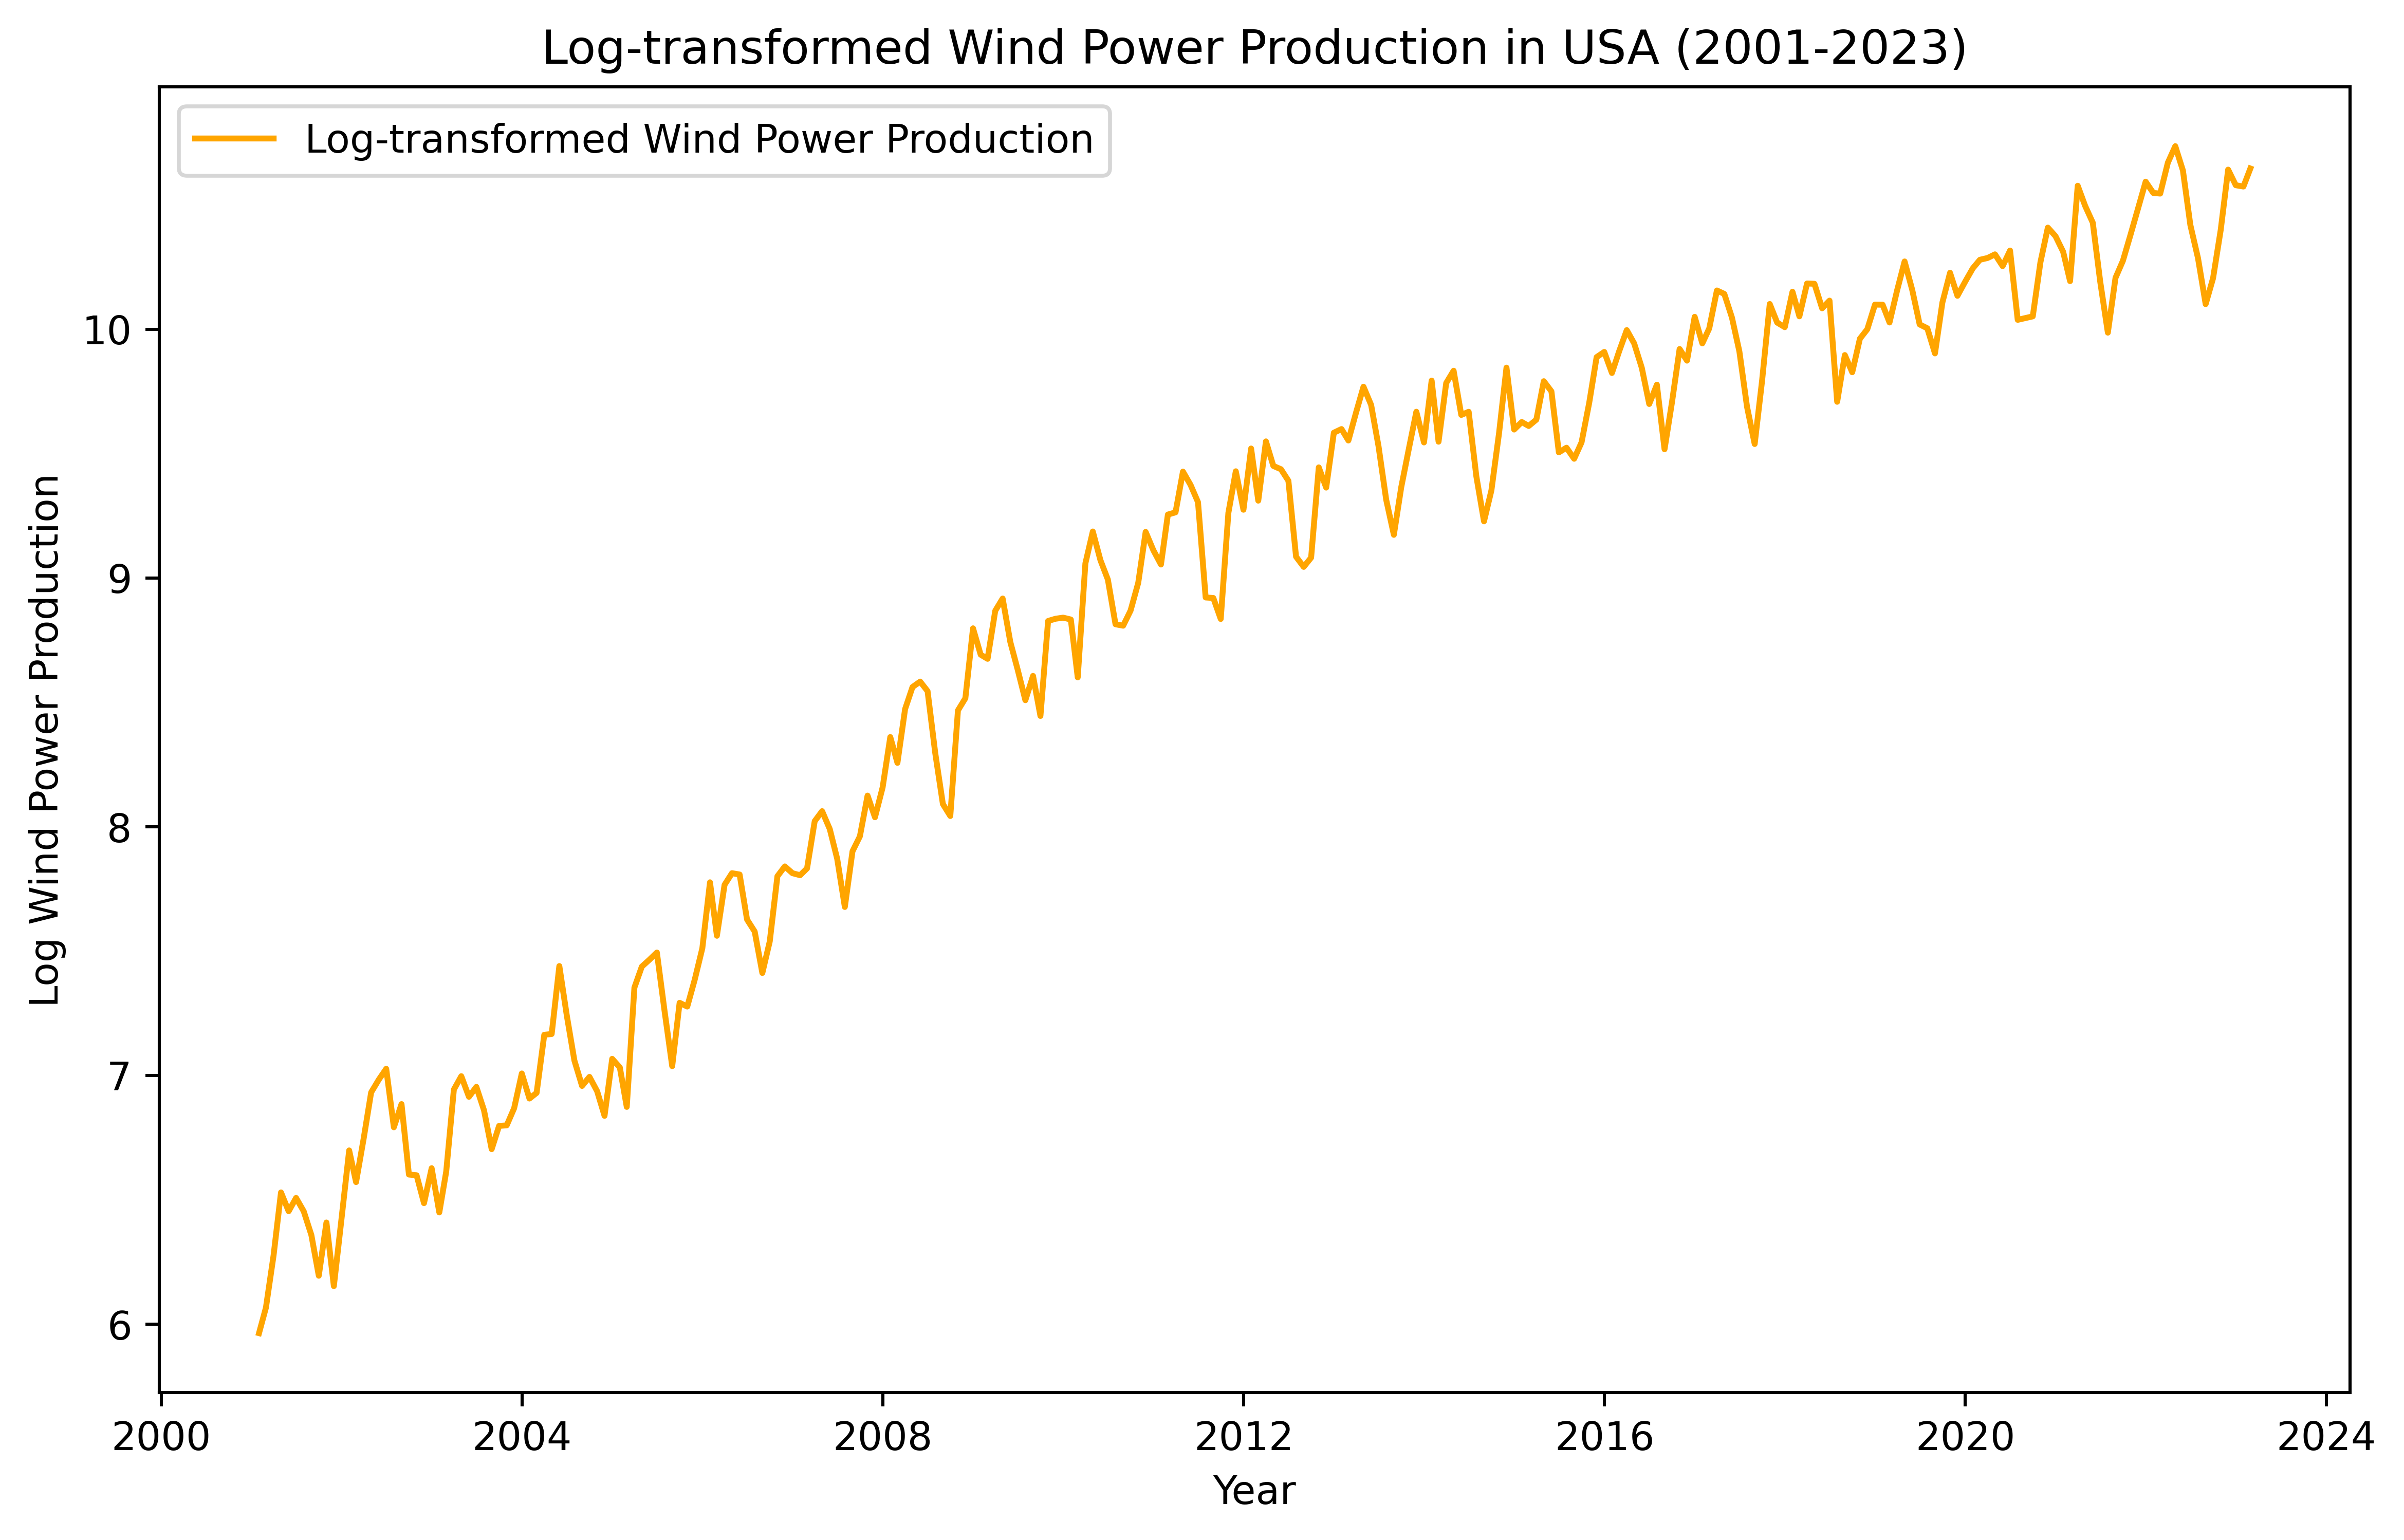

In [334]:
# Plot log-transformed wind power production
plt.figure(figsize=(10, 6), dpi=550)
plt.plot(wind_power_production_log, label="Log-transformed Wind Power Production", color='orange')
plt.title("Log-transformed Wind Power Production in USA (2001-2023)")
plt.xlabel("Year")
plt.ylabel("Log Wind Power Production")
plt.legend()

# Optionally, show the plot (if needed)
plt.show()

In [330]:
plt.savefig("high_quality_plot.png", dpi=300)  # Save with high resolution

<Figure size 640x480 with 0 Axes>

In [248]:
from statsmodels.nonparametric.smoothers_lowess import lowess

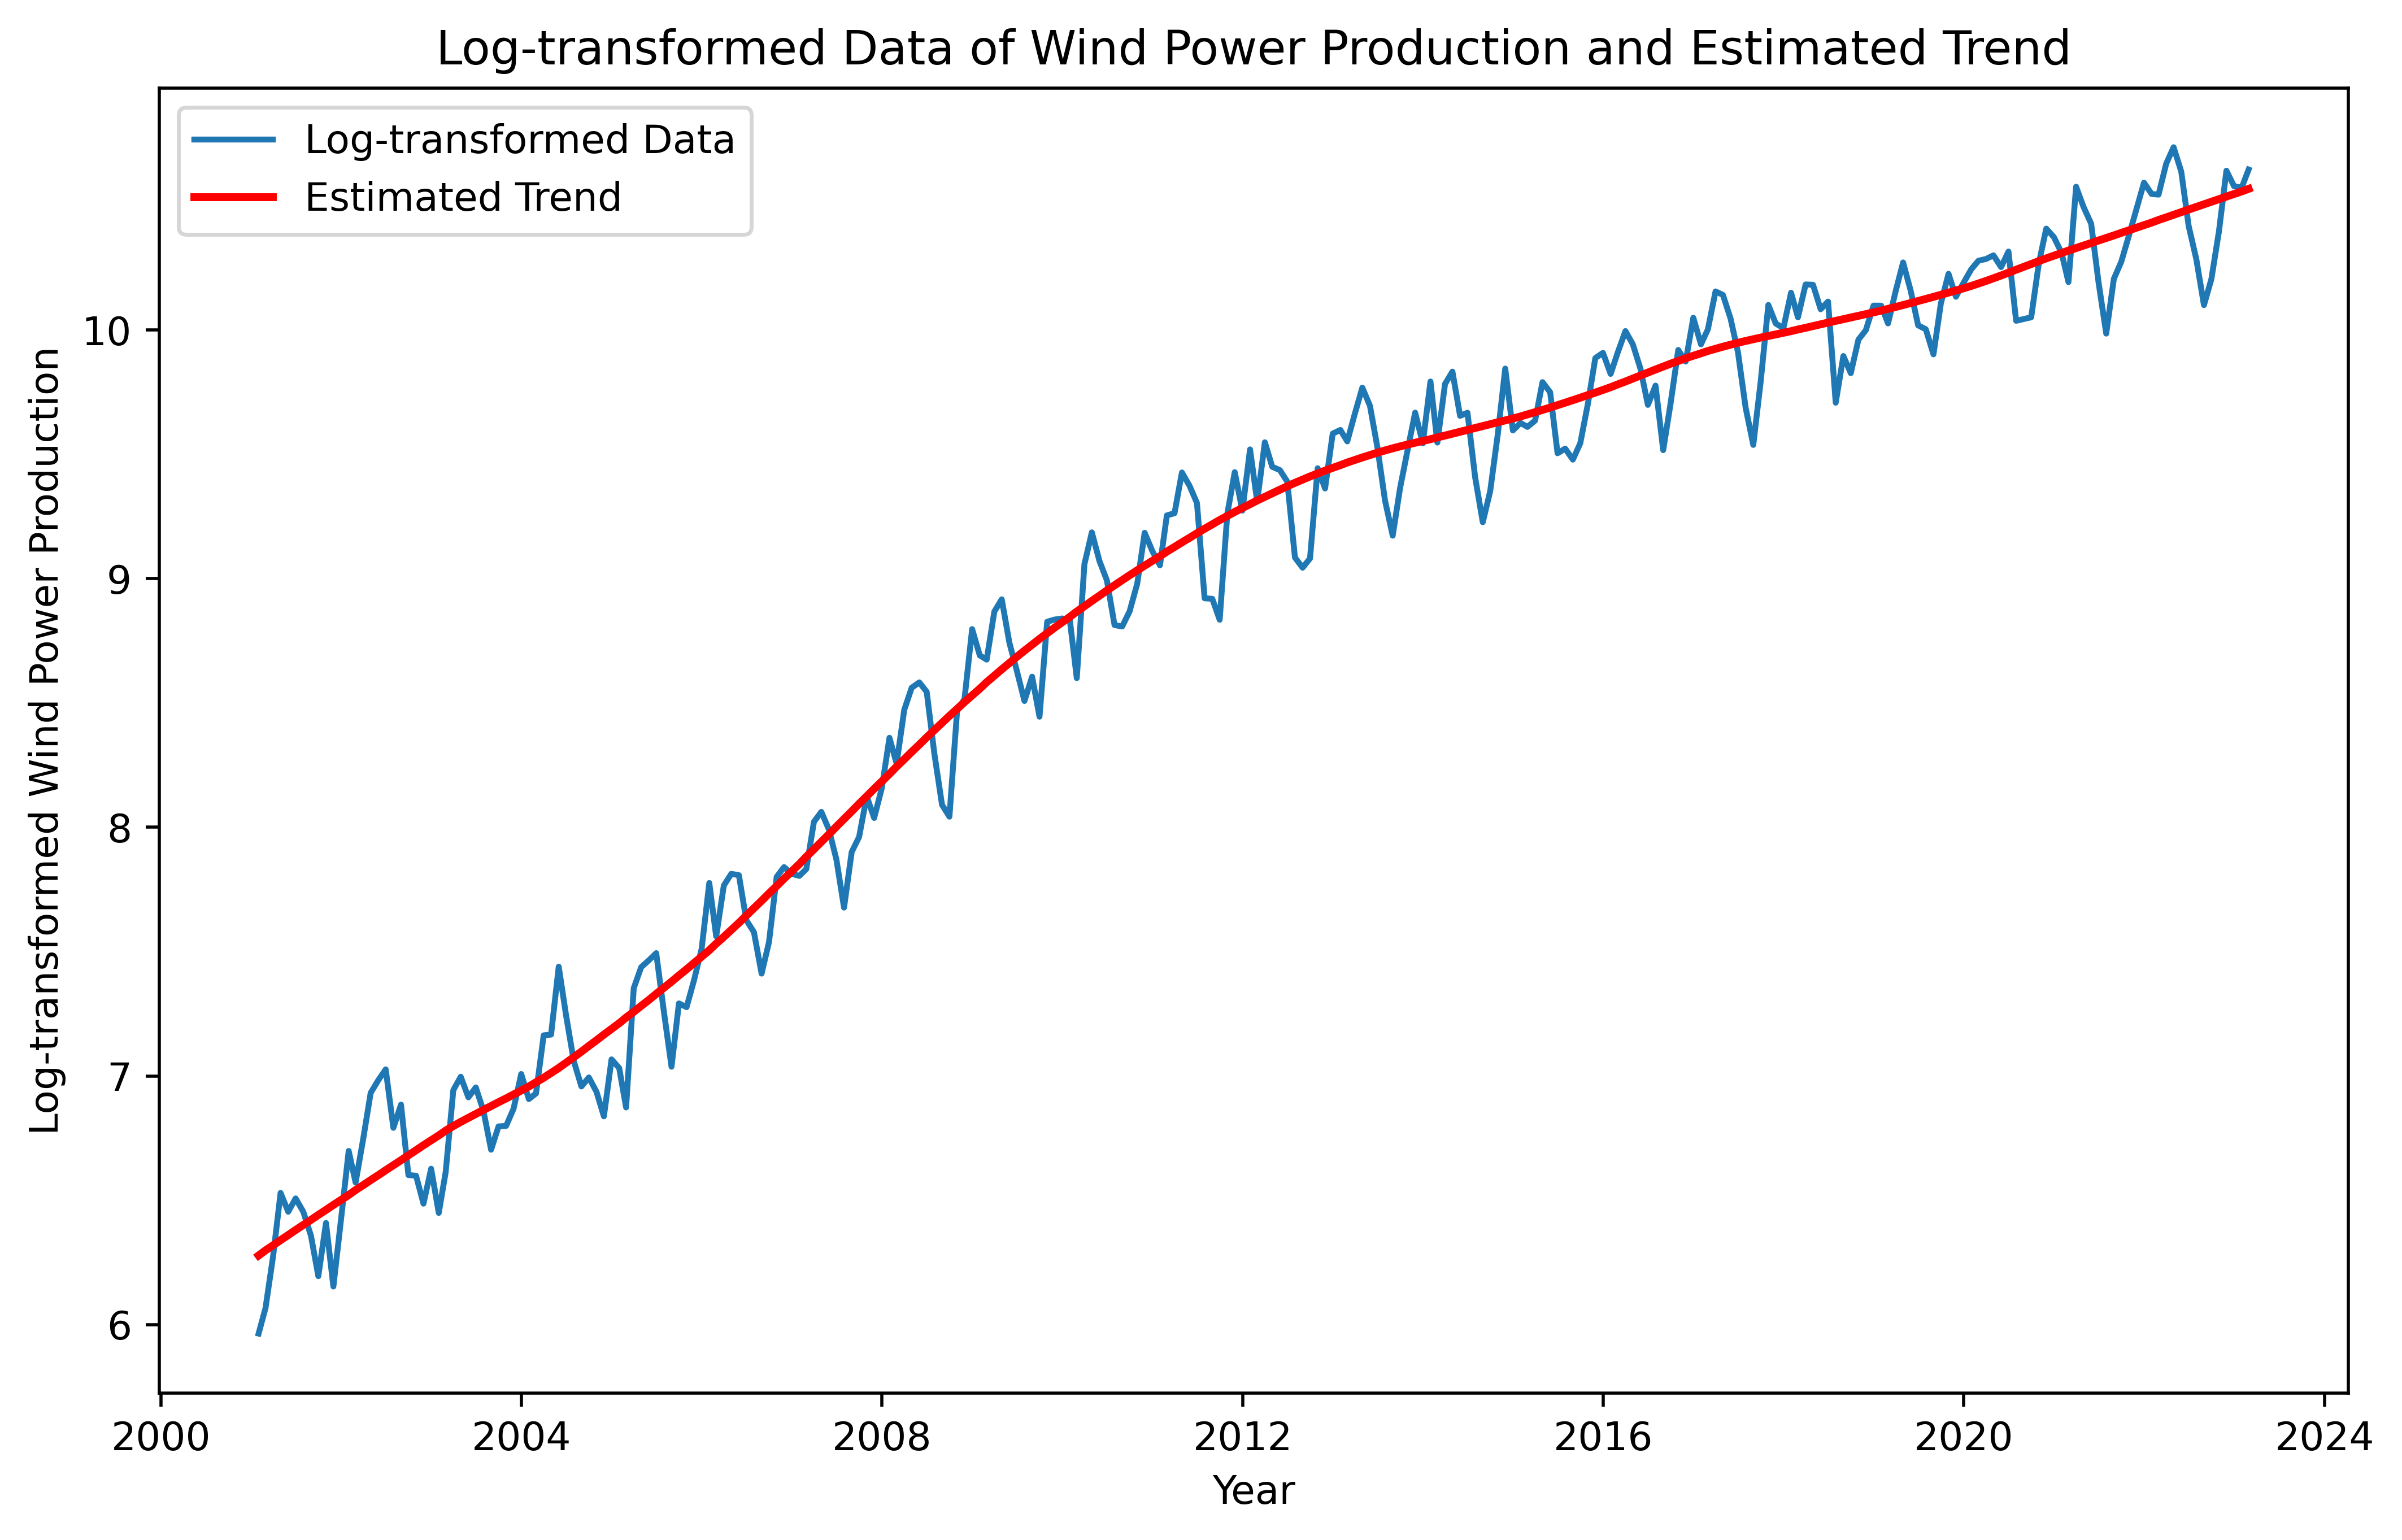

In [309]:
# Estimate trend with Lowess
trend = lowess(wind_power_production_log, np.arange(len(wind_power_production_log)), frac=0.2)[:, 1]

# Plot the observed series and trend
plt.figure(figsize=(10, 6), dpi=500)
plt.plot(wind_power_production_log, label='Log-transformed Data')
plt.plot(pd.Series(trend, index=wind_power_production_log.index), color='red', linewidth=2, label='Estimated Trend')
plt.title("Log-transformed Data of Wind Power Production and Estimated Trend")
plt.xlabel("Year")
plt.ylabel("Log-transformed Wind Power Production")
plt.legend()
plt.show()

In [252]:
# Calculate residuals
residuals = wind_power_production_log - trend

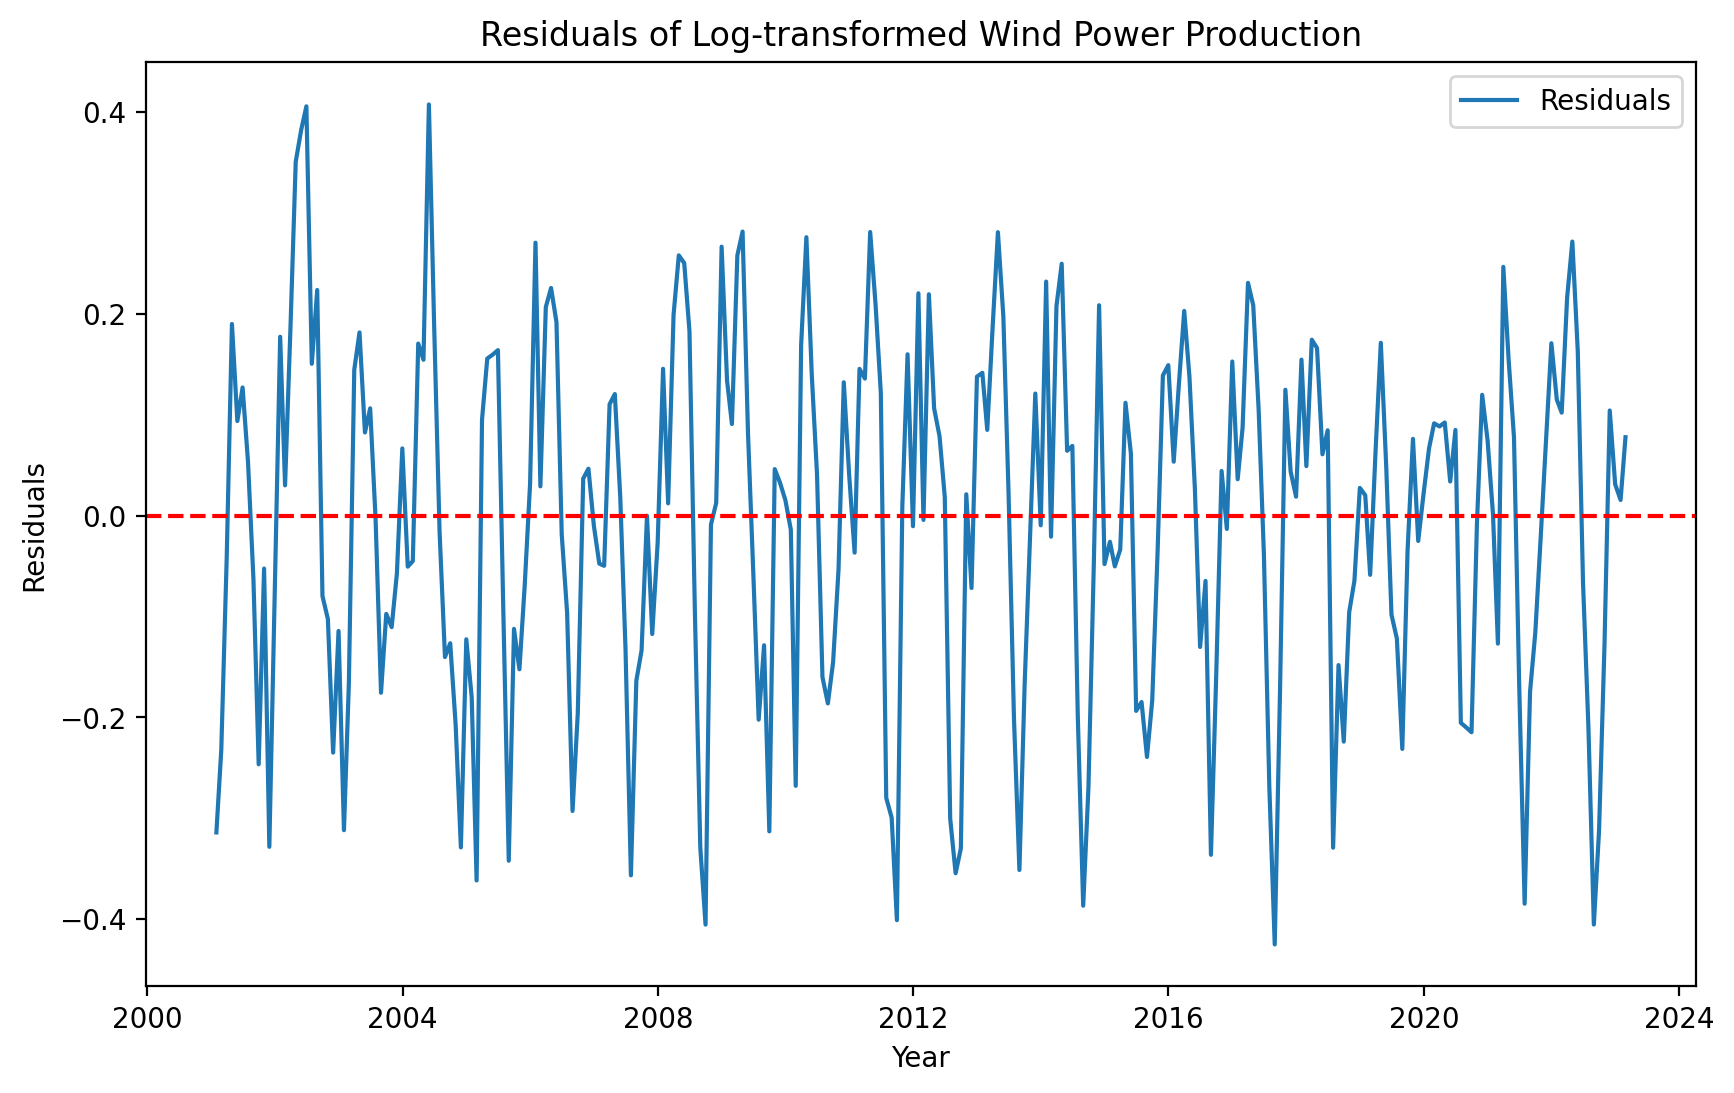

In [297]:
# Plot residuals
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals of Log-transformed Wind Power Production")
plt.xlabel("Year")
plt.ylabel("Residuals")
plt.legend()
plt.show()

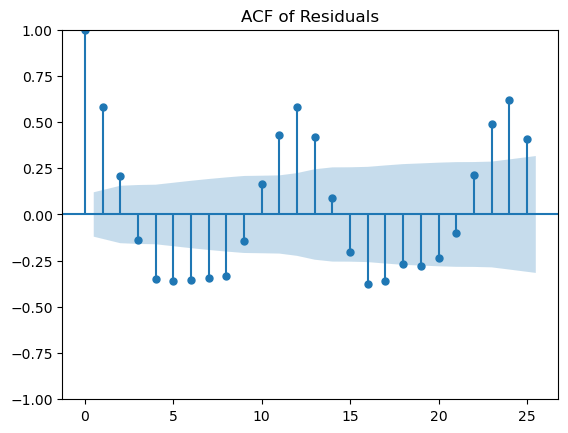

<Figure size 6000x4000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [325]:
# ACF plot of residuals
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, title="ACF of Residuals")
plt.figure(figsize=(12, 8), dpi=500)
plt.show()
plt.savefig('ACF.JPEG')

In [258]:
from statsmodels.tsa.arima.model import ARIMA

In [260]:
# Determine the optimal ARIMA model using BIC
p_max, q_max = 2, 2
bic = np.zeros((p_max + 1, q_max + 1))

for p in range(p_max + 1):
    for q in range(q_max + 1):
        model = ARIMA(residuals, order=(p, 0, q)).fit()
        bic[p, q] = model.bic

p_opt, q_opt = np.unravel_index(np.argmin(bic), bic.shape)
print(f"Optimal p: {p_opt}, Optimal q: {q_opt}")

Optimal p: 2, Optimal q: 1


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.


In [262]:
# Fit the optimal ARIMA model
arma_opt = ARIMA(residuals, order=(p_opt, 0, q_opt)).fit()
print(arma_opt.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  266
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 167.343
Date:                Wed, 23 Oct 2024   AIC                           -324.687
Time:                        14:37:54   BIC                           -306.769
Sample:                    01-31-2001   HQIC                          -317.489
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0042      0.004     -1.115      0.265      -0.011       0.003
ar.L1          1.4638      0.047     31.179      0.000       1.372       1.556
ar.L2         -0.6802      0.046    -14.751      0.0

In [264]:
# Split the data into training and testing sets
train_size = int(len(wind_power_production_log) * 0.9)
train, test = wind_power_production_log[:train_size], wind_power_production_log[train_size:]


In [266]:
# Fit the SARIMAX model on the training set
model = sm.tsa.SARIMAX(train, order=(p_opt, 0, q_opt), trend='c')

results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.65726D-01    |proj g|=  1.56392D+00

At iterate    5    f= -3.82281D-01    |proj g|=  1.01178D-01

At iterate   10    f= -3.83126D-01    |proj g|=  1.45782D-01

At iterate   15    f= -3.87646D-01    |proj g|=  2.77057D-01

At iterate   20    f= -3.88525D-01    |proj g|=  1.40580D-03

At iterate   25    f= -3.88526D-01    |proj g|=  3.88096D-04

At iterate   30    f= -3.88544D-01    |proj g|=  2.66537D-02

At iterate   35    f= -3.88672D-01    |proj g|=  1.09633D-02

At iterate   40    f= -3.88693D-01    |proj g|=  1.84070D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [268]:
# Forecast on the testing set
forecast = results.forecast(steps=len(test))

In [270]:
# Evaluate the forecast
mse = np.mean((forecast - test) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.06062370022442963


In [272]:
# Calculate the forecast_std value
forecast_std = np.sqrt(results.mse)

In [274]:
# Calculate the forecast_lower and forecast_upper values
forecast_lower = forecast - 1.96 * forecast_std
forecast_upper = forecast + 1.96 * forecast_std

In [276]:
# Create the forecast_df DataFrame with the appropriate data
forecast_df = pd.DataFrame({
    'Year': forecast.index,
    'Forecast': forecast,
    'Lower': forecast_lower,
    'Upper': forecast_upper
})

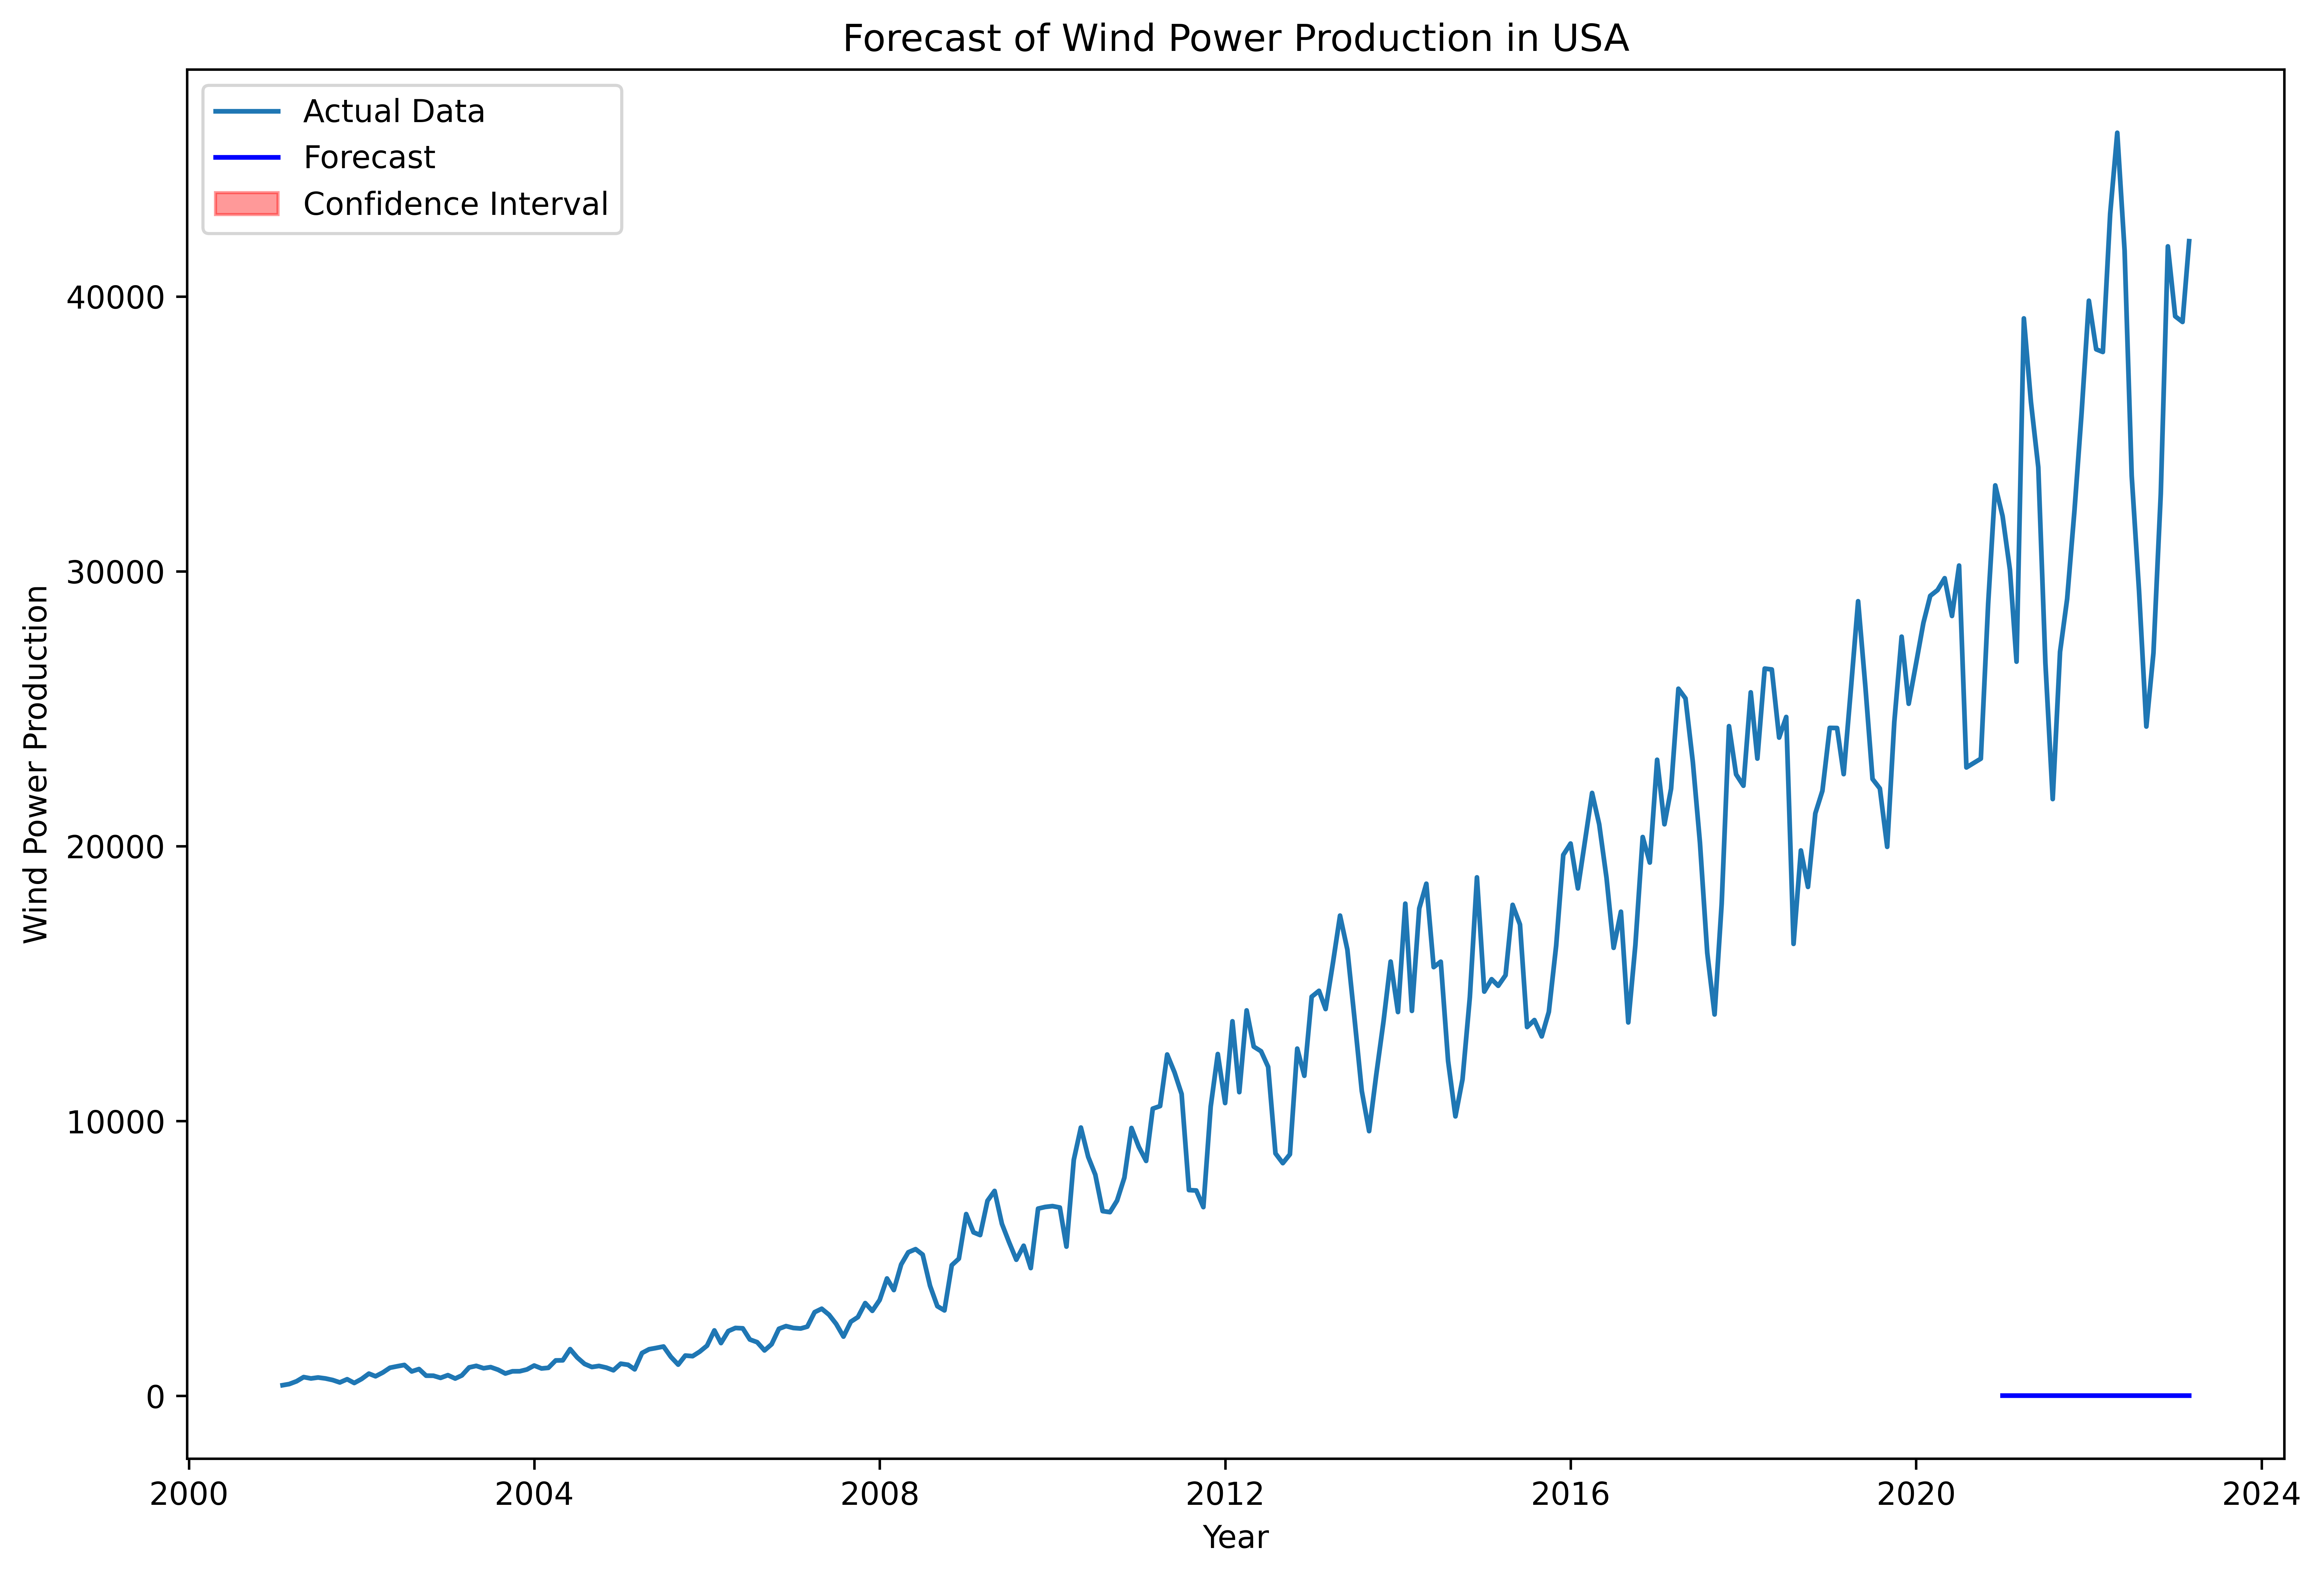

In [336]:
# Plot the original series and forecast
plt.figure(figsize=(12, 8), dpi=700)
plt.plot(wind_power_production, label="Actual Data")
plt.plot(forecast_df['Year'], forecast_df['Forecast'], color='blue', label="Forecast")
plt.fill_between(forecast_df['Year'], forecast_df['Lower'], forecast_df['Upper'], color='red', alpha=0.4, label="Confidence Interval")
plt.title("Forecast of Wind Power Production in USA")
plt.xlabel("Year")
plt.ylabel("Wind Power Production")
plt.legend()
# Save the figure
plt.savefig("wind_power_forecast.png", dpi=300, bbox_inches='tight')

plt.show()


In [280]:
print(data.shape)

(266, 126)


In [319]:
plt.savefig('wind_power_forecast.JPEG')

<Figure size 640x480 with 0 Axes>

In [338]:
 !pip install requests

In [340]:
import requests

url = 'https://example.com/path/to/your/file'  # Replace with your file URL
response = requests.get(url)

with open('downloaded_file', 'wb') as file:  # Replace 'downloaded_file' with your desired file name
    file.write(response.content)

print("File downloaded successfully.")

File downloaded successfully.
